In [1]:
#1 导入库
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import sklearn.metrics as sm
from sklearn.metrics import f1_score

In [2]:
#2 定义超参数
BATCH_SIZE = 16 #每批处理的数据
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #是否用GPU
EPOCHS = 10 #训练数据集的轮次

In [3]:
#3 构建pipeline，图像处理
pipeline = transforms.Compose([
    transforms.ToTensor(), #将图片转换成tensor（c*h*w）(0,255)转换成(0,1)
    transforms.Normalize((0.1307,),(0.3081,)) #正则化：降低模型复杂度，(0,1)转换成(-1,1)
])

In [4]:
#4 下载、加载数据
from torch.utils.data import DataLoader

#下载数据集
train_set = datasets.MNIST(root='./data',train=True,download=True,transform=pipeline)
test_set = datasets.MNIST(root='./data',train=False,download=True,transform=pipeline)

#加载数据
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)


G:\anaconda2\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_set.data.size(),train_set.data[1]
from PIL import Image
Image.fromarray(train_set.data[1].numpy())

In [6]:
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader
#
## 加载MNIST数据集
#class DealDataset(Dataset):
#
##读取数据、初始化数据
#    def __init__(self, folder, data_name, label_name, transform=None):
#        (train_set, train_labels) = load_data(folder, data_name,label_name)  #其实也可以直接使用torch.load(),读取之后的结果为torch.Tensor形式
#        self.train_set = train_set
#        self.train_labels = train_labels
#        self.transform = transform
#
#    def __getitem__(self, index):
#        img, target = self.train_set[index], int(self.train_labels[index])
#        if self.transform is not None:
#            img = self.transform(img)
#        return img, target
#
#    def __len__(self):
#        return len(self.train_set)
#
#def load_data(data_folder, data_name, label_name):
#    with gzip.open(os.path.join(data_folder, label_name), 'rb') as lbpath:  # rb表示的是读取二进制数据
#        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)
#
#    with gzip.open(os.path.join(data_folder, data_name), 'rb') as imgpath:
#        x_train = np.frombuffer(
#            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
#    return (x_train, y_train)
#
#train_dataset = DealDataset('MNIST_data/', "train-images-idx3-ubyte.gz",
#                           "train-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
#test_dataset = DealDataset('MNIST_data/', "t10k-images-idx3-ubyte.gz",
#                           "t10k-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
#
##train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
##test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
#
##加载数据
#train_loader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
#test_loader=DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

In [7]:
##插入代码，显示MNIST中的图片
#with open("./data/MNIST/raw/train-images-idx3-ubyte","rb") as f:
#    file=f.read()

In [8]:
#imagel=[int(str(item).encode('ascii'),16) for item in file[16:16+784]]
#print(imagel)

In [9]:
#import cv2
#import numpy as np
#imagel_np=np.array(imagel,dtype=np.uint8).reshape(28,28,1)
#print(imagel_np.shape)

In [10]:
#cv2.imwrite("digit.jpg",imagel_np)

In [11]:
#5 构建模型
class Digit(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,5) #灰度图片的通道为1，输出通道为10，卷积核大小为5
        self.conv2 = nn.Conv2d(10,20,3)
        self.fc1 = nn.Linear(20*10*10,500) #输入通道20 *10 *10，输出通道500
        self.fc2 = nn.Linear(500,10) #输入通道500，输出通道10（10个类别）
        
    def forward(self, x):
        input_size = x.size(0) #batch_size
        x = self.conv1(x) #输入：batch*1*28*28，输出：batch*10*24*24（28-5+1=24）
        x = F.relu(x) #激活函数 输出：batch*10*24*24
        x = F.max_pool2d(x,2,2) #输入：batch*10*24*24，输出：batch*10*12*12，步长：2
        
        x = self.conv2(x) #输入：batch*10*12*12，输出：batch*20*10*10（12-3+1=10）
        x = F.relu(x) #激活函数 输出：batch*20*10*10
        
        x = x.view(input_size,-1) #拉平，-1：自动计算维度，20*10*10=2000
        x = self.fc1(x) #输入：batch*2000，输出：batch*500
        x = F.relu(x) #激活函数 输出：batch*500
        x = self.fc2(x) #输入：batch*500，输出：batch*10
        #输出层的激活函数
        output = F.log_softmax(x,dim=1) #计算分类（多分类）后，每个数字的概率值，对数似然
        return output

In [12]:
#6  定义优化器
model = Digit().to(DEVICE)

optimizer = optim.Adam(model.parameters()) #默认learning_rate=0.001
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

In [13]:
#7 定义训练方法
def train_model(model,device,train_loader,optimizer,epoch):
    #模型训练
    model.train()
    #正确率
    correct = 0.0
    #每轮平均loss
    train_loss = 0.0
    for batch_index,(data,target) in enumerate(train_loader):
        #部署到DEVICE上去
        data, target = data.to(device),target.to(device)
        #梯度初始化为0
        optimizer.zero_grad()
        #训练结果
        output = model(data)
        #计算损失
        loss = F.cross_entropy(output,target)#交叉熵损失（多分类）
        #loss = nn.CrossEntropyLoss(x,target)
        #找到概率值最大的下标
        train_loss += loss
        pred = output.max(1,keepdim=True)[1] #0：值，1：索引
        for i in range(0,16):
            #存储预测值和真实值
            t_Pred.append(pred[i].item())
            t_Target.append(target[i].item())
        #累计正确率
        correct += pred.eq(target.view_as(pred)).sum().item()
        #反向传播
        loss.backward()#然后parameters就有梯度值了
        #参数优化
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    Accuracy = 100.0 * correct / (len(train_loader.dataset))   
    train_Loss.append(train_loss)
    train_Accuracy.append(Accuracy)
    print("Train Epoch: {} \t Loss : {:.6f},Accuracy : {:.3f}\n".format(epoch,loss.item(),Accuracy))

In [14]:
#8 定义测试方法
def test_model(model,device,test_loader):
    #模型验证
    model.eval()
    #正确率
    correct = 0.0
    #测试损失
    test_loss = 0.0

    with torch.no_grad(): #不会计算梯度，也不会反向传播
        for data,target in test_loader:
            #部署到DEVICE上去
            data, target = data.to(device),target.to(device)
            #测试数据
            output = model(data)
            #计算测试损失
            test_loss += F.cross_entropy(output,target).item()
            #找到概率值最大的下标
            pred = output.max(1,keepdim=True)[1] #0：值，1：索引
            #pred = output.argmax(dim=1)
            #pred = torch.max(output,dim=1)
            
            for i in range(0,16):
                #存储预测值和真实值
                Pred.append(pred[i].item())
                Target.append(target[i].item())
            
            #累计正确率
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        Accuracy = 100.0*correct / len(test_loader.dataset)

        test_Loss.append(test_loss)
        test_Accuracy.append(Accuracy)
        
        print("Test -- Average loss : {:.4f},Accuracy : {:.3f}\n".format(test_loss,Accuracy))

In [15]:
#9 调用方法

#定义损失函数和精度数组
train_Loss = []
train_Accuracy = []
train_F1 = []
test_Loss = []
test_Accuracy = []
test_F1 = []

for epoch in range(1, EPOCHS+1):
    #定义预测值和真实值列表
    Pred = []
    Target = []
    t_Pred = []
    t_Target = []
    
    train_model(model,DEVICE,train_loader,optimizer,epoch)
    test_model(model,DEVICE,test_loader)
    #test_model(model,DEVICE,train_loader)
    
    #保存模型参数
    torch.save(model.state_dict(),"./model/" + str(epoch) + "_model.pth")
    
    #F1
    train_f1 = f1_score(t_Target,t_Pred,average='micro')
    test_f1 = f1_score(Target,Pred,average='micro')
    print("F1_score:",test_f1)
    train_F1 = np.append(train_F1,train_f1)
    test_F1 = np.append(test_F1,test_f1)
    
    #打印混淆矩阵
    print("训练集的混淆矩阵：")
    confu = sm.confusion_matrix(t_Target,t_Pred)
    print(confu)
    print("测试集的混淆矩阵：")
    confu = sm.confusion_matrix(Target,Pred)
    print(confu)
    # 获取分类报告
    #cr = sm.classification_report(target，output)
    #print(cr)

G:\anaconda2\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 	 Loss : 0.011228,Accuracy : 96.580

Test -- Average loss : 0.0032,Accuracy : 98.390

F1_score: 0.9839
训练集的混淆矩阵：
[[5825    3   11    7    4    9   32    8   17    7]
 [   6 6607   34   11    8    4    5   20   36   11]
 [  20   24 5721   43   23    0   10   62   43   12]
 [  16    9   60 5886    1   61    2   37   37   22]
 [  13   20   10    0 5636    2   19   22   12  108]
 [  22   14    3   64    5 5189   35    9   56   24]
 [  28   12    7    0   16   24 5804    5   21    1]
 [  13   18   50   15   21    3    5 6070    8   62]
 [  28   38   31   37   19   44   27   14 5558   55]
 [  27   14    4   20   98   29    7   72   26 5652]]
测试集的混淆矩阵：
[[ 968    1    2    1    0    1    2    0    0    5]
 [   0 1134    0    0    0    0    0    0    1    0]
 [   0    0 1020    1    0    0    0   10    1    0]
 [   0    0    0 1004    0    4    0    1    1    0]
 [   0    1    2    2  964    0    2    1    2    8]
 [   1    0    1    8    0  881    1    0    0    0]
 [   6    4  

Train Epoch: 8 	 Loss : 0.064246,Accuracy : 99.720

Test -- Average loss : 0.0036,Accuracy : 98.770

F1_score: 0.9877
训练集的混淆矩阵：
[[5917    0    1    0    0    0    3    0    1    1]
 [   1 6727    5    1    0    1    1    4    1    1]
 [   1    4 5934    5    1    0    2    8    2    1]
 [   1    1    4 6116    0    3    0    2    3    1]
 [   0    0    1    0 5825    0    1    2    1   12]
 [   0    1    0    4    1 5409    2    0    3    1]
 [   2    1    1    0    2    3 5908    0    1    0]
 [   0    5    6    1    2    0    0 6240    2    9]
 [   1    1    3    6    0    3    2    0 5833    2]
 [   2    0    0    3    9    2    0    7    3 5923]]
测试集的混淆矩阵：
[[ 975    1    0    0    0    0    2    0    1    1]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   2    3 1014    0    1    0    0    5    7    0]
 [   0    0    1 1003    0    3    0    0    2    1]
 [   0    0    0    0  970    0    3    0    0    9]
 [   1    0    0    6    0  881    3    0    0    1]
 [   4    3  

In [16]:
#读取模型，加载参数
model = Digit()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

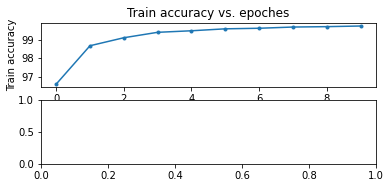

In [17]:
#绘制折线图
import matplotlib.pyplot as plt
#测试集
x1 = range(0, 10)
x2 = range(0, 10)
x3 = range(0, 10)
y1 = train_Accuracy
y2 = train_Loss
y3 = train_F1 

plt.subplot(3, 1, 1)
plt.plot(x1, y1, '.-')
plt.title('Train accuracy vs. epoches')
plt.ylabel('Train accuracy')
plt.subplot(3, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.subplot(3, 1, 3)
plt.plot(x3, y3, '.-')
plt.xlabel('F1 score vs. epoches')
plt.ylabel('F1 score')
plt.savefig("train_acc_loss_f1_Adam.jpg")
plt.show()


#训练集
x4 = range(0, 10)
x5 = range(0, 10)
x6 = range(0, 10)
y4 = test_Accuracy
y5 = test_Loss
y6 = test_F1 

plt.subplot(3, 1, 1)
plt.plot(x4, y4, '.-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(3, 1, 2)
plt.plot(x5, y5, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.subplot(3, 1, 3)
plt.plot(x6, y6, '.-')
plt.xlabel('F1 score vs. epoches')
plt.ylabel('F1 score')
plt.savefig("test_acc_loss_f1_Adam.jpg")
plt.show()
